In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://raw.githubusercontent.com/tyokokur/findat/main/nfh/'

COLORS = [(228/255,26/255,28/255), (55/255,126/255,184/255), (77/255,175/255,74/255), (152/255,78/255,163/255), (255/255,127/255,0/255)] # Colors from https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5
COLORS2 = [(228/255,26/255,28/255),  (152/255,78/255,163/255), (55/255,126/255,184/255), (255/255,255/255,153/255), (77/255,175/255,74/255)] # Colors from https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5
BACKS = [(127/255,201/255,127/255), (190/255,174/255,212/255), (255/255,255/255,153/255), (56/255,108/255,176/255)]
COLORS_UCB = {'bb': (0/255, 39/255, 122/255), 'fr': (59/255, 126/255, 161/255), 'pa': (70/255, 83/255, 94/255)}
    
#     \xdefinecolor{ucbbb}{RGB}{0, 39, 122}  %Berkeley Blue; HEX #00277A
# \xdefinecolor{ucbfr}{RGB}{59, 126, 161}  %Founder's Rock; HEX #3B7EA1
# \xdefinecolor{ucbpa}{RGB}{70, 83, 94}  %Pacific; HEX #46535E

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


In [2]:
def Discr_cumsum_ph(sequence, block_N, smear, ph, phos=False):
    N = len(sequence)
    x = np.linspace(0,N,N)
    y = np.asarray(Norm_cumsum_ph(sequence, ph, phos))

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    import matplotlib.colors as mcolors
    cmaplist = list( map(mcolors.BASE_COLORS.get, ['b', 'r', 'g', 'm']) )

    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist) #new cmap

    dydx = np.ndarray(0)
    for i in range(round(N/smear)-1):
        m = (Norm_cumsum_ph(sequence, ph, phos)[(i+1)*smear]-Norm_cumsum_ph(sequence, ph, phos)[i*smear])/smear
        dydx = np.concatenate([dydx, m*np.ones(smear)], axis = 0)

    i = N-smear*(round(N/smear)-1)
    m = (Norm_cumsum_ph(sequence, ph, phos)[N-1]-Norm_cumsum_ph(sequence, ph, phos)[N-i-1])/smear
    dydx = np.concatenate([dydx, m*np.ones(i)], axis = 0)

    zero_thresh = 10
    norm_set = [dydx.min()]
    for i in range(block_N-1):
        m = (dydx.max() - dydx.min())/block_N
        norm_set += [(i+1)*m + dydx.min()]
    if abs((i+1)*m + dydx.min()) < zero_thresh:
        zero = i
        zero_thresh = abs((i+1)*m + dydx.min())
        norm_set += [dydx.max()]

    norm = BoundaryNorm(norm_set, cmap.N)
    lc = LineCollection(segments, lw=3, cmap=cmap, norm=norm, zorder = 5, label="_no_label") #Bring to front of plot
    lc.set_array(dydx)
    return [lc, dydx, norm_set]

def aa_to_charge(aa):
    switcher = {
      "E": -1,
      "R": +1,
      "K": +1,
      "D": -1,
      "H": +0, #+1 #not part of original gene
    }
    return switcher.get(aa, 0) #If not in switcher, charge = 0

def charge_dist_ph(sequence, ph, phos=False):
    charge_dist = []
    for i in sequence:
        charge_dist.append(aa_to_charge_ph(i, ph, phos))

    return charge_dist

def aa_to_charge_ph(aa, ph, phos=False):
    #Source: https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart
    pKa = {
      "D": [3.65, -1*np.inf],
      "E": [4.25, -1*np.inf],
      "K": [np.inf, 10.53],
      "R": [np.inf, 12.48],
      "H": [np.inf, 6.00],
    }

    #Henderson Hasselbalch
    ## HH --> pH  - pKa = log10([base]/[acid])

    #Example: pH 2.4 / pOH 11.6
    ## [D]: 2.4 - 3.65 = -1.25 = log10([A-]/[HA]) -->  [A-]/[HA] = 0.056 
    ##      --> ch = Z- * [A-]/([A-] + [HA])  = -0.053
    ## [K]: 11.6 - 10.53 = 1.07 = log10([BH+]/[B]) --> [BH+]/[B] = 11.75
    ##      --> ch = X+ * [BH+]/([BH+] + [B]) = +0.92

    a_ha = 10**(ph - pKa.get(aa,[np.inf]*2)[0])
    bh_b = 10**(-1*(ph-pKa.get(aa,[-1*np.inf]*2)[1]))
    
    if phos and (aa == 's' or aa == 't'):
        ch = -1.5 ## ASSUMPTION of -1.5 for phosphorylated 
    else: 
        ch = bh_b/(1 + bh_b) - a_ha/(1 + a_ha)

    return ch



def chi_dist(sequence):
  chi_dist = []
  for i in sequence: 
    chi_dist.append(aa_to_chi(i))

  return chi_dist

def aa_to_chi(aa):
    chi_max = 3.00
    switcher = {
      "G": chi_max, "P": chi_max, "C": chi_max, "M": chi_max, "A": chi_max, "L": chi_max, "V": chi_max, "I": chi_max,
      "Y": 0.6, "Q": 0.6, "H": 0.6, "F": 0.6, "W": 0.6, 
      "E": 0.0, "D": 0.0, "N": 0.0, #N (Asparagine added, polar uncharged)
      "K": 0.0, "R": 0.0,
      "S": 0.6, "T": 0.6, 
      "s": 0.6, "t": 0.6 #phosphorylated S and T
    }
    return switcher.get(aa, "ERROR: {:s}".format(aa))

def Norm_cumsum_ph(sequence, ph, phos=False):
    L_cumsum = np.cumsum(charge_dist_ph(sequence, ph, phos)[0:len(sequence)])
    if (abs(min(L_cumsum)) > abs(max(L_cumsum))): 
        L_cumsum_max = abs(min(L_cumsum))
    else:
        L_cumsum_max = abs(max(L_cumsum))
    return L_cumsum / L_cumsum_max

def find_charge_avg_ph(sequence, NsK_list, ph, phos=False):
    Num_blocks = len(NsK_list)

    start = 0
    end = 0
    Nsi = len(sequence)
    L_final = []
    L_dist = charge_dist_ph(sequence, ph, phos)

    for i in range(Num_blocks):
        NsK = NsK_list[i]
        end += NsK
        avg = sum(L_dist[start:end])/NsK

        print("Charge Block {:d}: [{:d} {:d}] = {:.6f}".format(i+1, start, end, avg))
        L_inter = (np.ones(NsK)*avg).tolist()
        L_final += L_inter
        start += NsK
    return L_final

def find_charge_change(seq_dydx, seq_normset):
    prev = -1
    prev_count = 0
    change_s = []
    for (count, i) in enumerate(seq_dydx):
        curr = 0
        for j in range(len(seq_normset)-1): 
            if seq_normset[j] <= i < seq_normset[j+1]: curr = j
            if j+1 == len(seq_normset)-1: 
                if seq_normset[j] <= i <= seq_normset[j+1]: curr = j

        if (curr != prev) & (count!=0): 
            change_s += [count]
            prev_count = count
        prev = curr
    change_s += [len(dydx)]
    return change_s

def find_chi_avg(sequence, NsK_list):
    Num_blocks = len(NsK_list)
    start = 0
    end = 0
    Nsi = len(sequence)
    L_final = []
    L_dist = chi_dist(sequence)

    for i in range(Num_blocks):
        NsK = NsK_list[i]
        end += NsK
        avg = sum(L_dist[start:end])/NsK

        print("Chi Block {:d}: [{:d} {:d}] = {:.6f}".format(i+1, start, end, avg))
        L_inter = (np.ones(NsK)*avg).tolist()
        L_final += L_inter
        start += NsK
    return L_final

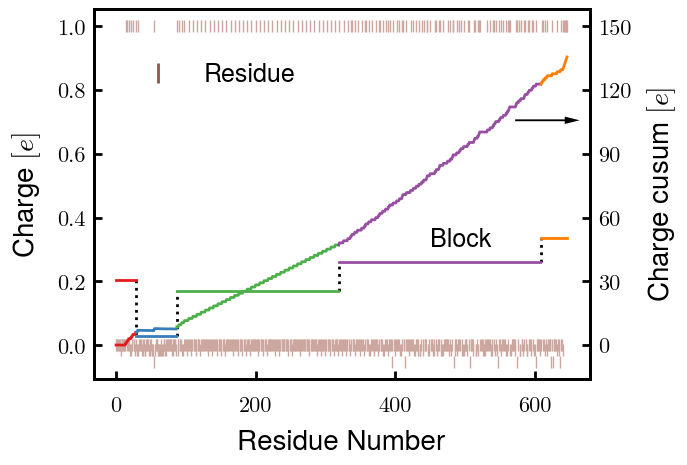

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker

## BASED ON ALGORITHM FROM AA_discretization BUT REFORMATTED
H_seq = "MGCWYMSEFTSMSTHIKVKSEEKIKVVEKSEKETVIVEEQTEEIQVTEEVTEEEDKEAQGEEEEEAEEGGEEAATTSPPAEEAASPEKEtKSPVKEEAKsPAEAKsPAEAKsPAEAKsPAEVKsPAVAKsPAEVKsPAEVKsPAEAKsPAEAKsPAEVKsPATVKsPGEAKsPAEAKsPAEVKsPVEAKsPAEAKsPASVKsPGEAKsPAEAKsPAEVKsPATVKsPVEAKsPAEVKsPVTVKsPAEAKsPVEVKsPAsVKsPSEAKsPAGAKsPAEAKsPVVAKsPAEAKsPAEAKPPAEAKsPAEAKsPAEAKsPAEAKsPAEAKsPVEVKsPEKAKsPVKEGAKSLAEAKsPEKAKsPVKEEIKPPAEVKsPEKAKsPMKEEAKsPEKAKTLDVKsPEAKtPAKEEAKRPADIRsPEQVKsPAKEEAKsPEKEETRTEKVAPKKEEVKsPVEEVKAKEPPKKVEEEKTPAtPKTEVKESKKDEAPKEAQKPKAEEKEPLTEKPKDsPGEAKKEEAKEKKAAAPEEETPAKLGVKEEAKPKEKAEDAKAKEPSKPSEKEKPKKEEVPAAPEKKDTKEEKTTESKKPEEKPKMEAKAKEEDKGLPQEPSKPKTEKAEKSSSTDQKDSQPSEKAPEDKLLEHHHHHH"
ph = 2.40
seq = H_seq
phos = False

f , ax2 = plt.subplots()

ax2.plot(charge_dist_ph(seq, ph, phos), '|', color=tjy.lighten_color('tab:brown', 0.5), zorder = 0, ms=8, mew=1, markerfacecolor='w') #Raw Data

bb = [0, 29, 87, 319, 609, 647] ## From prev with smear 29 and bin 4
ba = [0.204967, 0.027801, 0.170493, 0.261110, 0.336030] ## From prev with smear 29 and bin 4
rax = plt.twinx(ax2)
cusum = np.cumsum(charge_dist_ph(H_seq, ph, phos)[0:len(H_seq)])
for i in range(5): rax.plot(np.arange(bb[i],bb[i+1]), cusum[bb[i]:bb[i+1]], c=COLORS[i], lw=2)
# rax.text(400, 100, 'Cusum', fontsize=14)
rax.arrow(0.85,0.7, 0.1, 0, width=0.005, head_width=0.02, ec='None', fc='k', transform=rax.transAxes, clip_on=False)

rax.set_ylim([-16, 158])
rax.set_yticks([0, 30, 60, 90, 120, 150])
rax.set_ylabel(r'Charge cusum $[e]$')

for i in range(4): ax2.plot([bb[i+1],bb[i+1]], [ba[i], ba[i+1]], 'k:', lw=2)
for i in range(5): ax2.plot(np.arange(bb[i], bb[i+1]), np.ones(bb[i+1]-bb[i])*ba[i], c=COLORS[i], lw=2)
ax2.text(450, 0.31, 'Block', fontsize=18)

ax2.set_xlabel("Residue Number")
ax2.set_ylabel("Charge "r"$[e]$")
ax2.legend([Line2D([0], [0], color='tab:brown', marker='|', ls='', ms=14, mew=2.0, markerfacecolor='w')],["Residue"], bbox_to_anchor=(0.01, 0.95), loc="upper left",frameon=False,fontsize=18)
tjy.ticks([ax2, rax])

# plt.savefig('./imgs/NFH_disc.eps')
plt.show()

In [3]:
## NFH
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

from datetime import datetime
labs =  ['004', '005', '006', '008', '010', '015', '020', '030', '040', '050']
labs =  ['002', '003', '0035', '004', '005', '006', '008', '010', '015', '020', '030', '040', '050', '070']
tack = [0]*len(labs) #see add for options
#tack[8:9] = [1]*2
#tack[10:] = [2]*6
add = ['', '_1C', '_']
read_list = ['pha/phf400_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
print("Files:\n", read_list)
read_list = [GIT+i for i in read_list]
algs = ['thresh', 'maxpt', 'norm']

##########################################
##########################################
norms = [250, 55, 32.9] # 31.5
thresh = 1e-04
##########################################
##########################################

algind = 2
print(algs[algind])
LH = np.zeros(len(read_list))
print("[", end="")
for i in range(len(read_list)): 
  LH[i] = tjy.H_find(read_list[i], alg=algs[algind], thresh=thresh)
  print(LH[i], end="")
  if i!=(len(read_list)-1): print(", ", end="")
print("]")
####################

SrCs = [float(i) for i in labs]
SrCs[2] = 3.5
Sr_equil = LH
Sr_equil = np.divide(Sr_equil,  norms[algind])
CsDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in SrCs]
print(CsDeb)

#Sr2014 pH2.4 fitted in Illustrator
x = [4, 4.5, 5, 6, 15, 30, 55]
y = [1.3, 0.98, 0.68, 0.48, 0.38, 0.26, 0.12]
xDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in x]
print(xDeb)

Files:
 ['pha/phf400_c002.dat', 'pha/phf400_c003.dat', 'pha/phf400_c0035.dat', 'pha/phf400_c004.dat', 'pha/phf400_c005.dat', 'pha/phf400_c006.dat', 'pha/phf400_c008.dat', 'pha/phf400_c010.dat', 'pha/phf400_c015.dat', 'pha/phf400_c020.dat', 'pha/phf400_c030.dat', 'pha/phf400_c040.dat', 'pha/phf400_c050.dat', 'pha/phf400_c070.dat']
norm
[44.31784654445123, 39.10682895172387, 36.33618772314233, 32.88634733284891, 22.215158730320006, 18.334582640970304, 14.935922034201884, 13.526216516171019, 12.23197300304465, 11.667605232951775, 11.081436820292529, 10.773556645607421, 10.581059556336518, 10.355077583723544]
[6.816703127353185, 5.565814796683214, 5.152943210380796, 4.820137006686982, 4.311261603125781, 3.935625385563126, 3.4083515636765926, 3.048522315039426, 2.489108047111568, 2.1556308015628907, 1.7600651792185937, 1.524261157519713, 1.363340625470637, 1.1522331302607458]
[4.820137006686982, 4.54446875156879, 4.311261603125781, 3.935625385563126, 2.489108047111568, 1.7600651792185937, 1

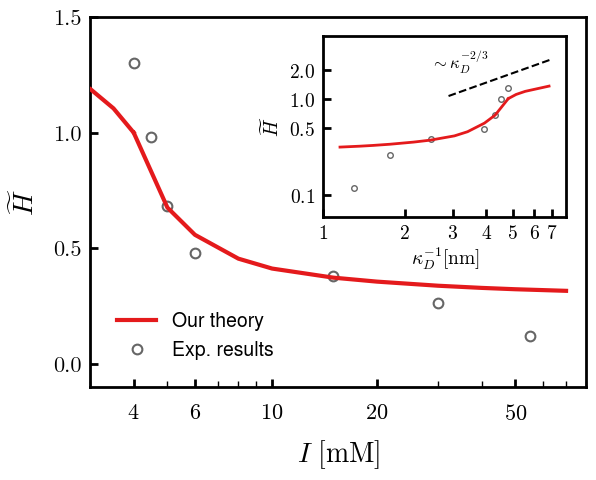

In [48]:
f, ax = plt.subplots(1,1)

COL = COLORS[0]
# COL = COLORS_UCB['fr']

# Main
ax.plot(SrCs[3:], Sr_equil[3:], '-', c=COL, lw=3, markerfacecolor='w', zorder=3, label="Our theory")
ax.plot(SrCs[:4], Sr_equil[:4], '-', c=COL, lw=3, markerfacecolor='w', zorder=3, label="_Our theory")
ax.plot(x, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="Exp. results")

# Inset
axins = ax.inset_axes([0.47, 0.46, 0.49, 0.49])
axins.plot(CsDeb[3:], Sr_equil[3:], '-', c=COL, lw=2, markerfacecolor='w', zorder=3, label="Our theory")
axins.plot(CsDeb[:4], Sr_equil[:4], '-', c=COL, lw=2, markerfacecolor='w', zorder=3, label="_Our theory")
axins.plot(xDeb, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.0, ms=4, markerfacecolor='w',label="Exp. results")

ag_x = np.array([2.9,7])
ag_y = 0.55*ag_x*(2/3) # Zhulina 1995 Alexander-de Gennes 2/3 scaling
axins.plot(ag_x, ag_y, 'k--', lw=1.5)
axins.text(2.5, 2.0, r'$\sim\kappa_D^{-2/3}$', fontsize=12)

## Formatting
axins.set_xscale('log')
axins.set_xlim(1.0, 7.9)
axins.set_xticks([1, 2, 3, 4, 5, 6, 7])
axins.xaxis.set_minor_locator(ticker.NullLocator())
axins.xaxis.set_minor_formatter(ticker.NullFormatter())
axins.set_yscale('log')
axins.set_ylim(0.06, 4.5)
axins.set_yticks([0.1, 0.5, 1.0, 2.0])
axins.yaxis.set_minor_locator(ticker.NullLocator())
axins.set_ylabel(r'$\widetilde{H}$', fontsize=14, labelpad=4)
axins.set_xlabel(r'$\mathbf{\kappa}_D^{-1} [\mathrm{nm}]$', fontsize=14, labelpad=2)
axins.tick_params(axis='x', which='major', pad=5)

ax.legend(loc=3)
ax.set_xscale('log')
ax.set_xlim(3.0, 80)
ax.set_xticks([4, 6, 10, 20, 50])
ax.set_ylim(-0.1, 1.5)
ax.set_yticks([0.0, 0.5, 1.0, 1.5] )
ax.set_ylabel(r'$\widetilde{H}$')
ax.set_xlabel(r'$I\ [\mathrm{mM}]$')

class xScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%d$" # New precision
class yScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%.1f$" # New precision
ax.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
axins.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
axins.yaxis.set_major_formatter(yScalarFormatterClass(useMathText=True))
axins.xaxis.set_tick_params(labelsize=14)
axins.yaxis.set_tick_params(labelsize=14)

tjy.ticks()

# plt.savefig('./imgs/hprof.pdf')
plt.show()

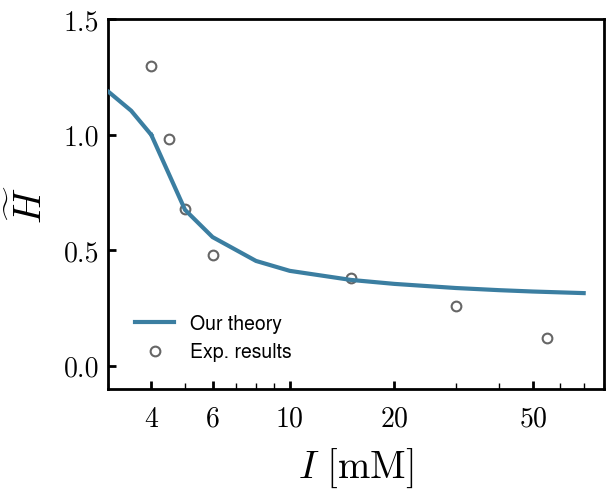

In [10]:
f, ax = plt.subplots(1,1)

# COL = COLORS[0]
COL = COLORS_UCB['fr']

# Main
ax.plot(SrCs[3:], Sr_equil[3:], '-', c=COL, lw=3, markerfacecolor='w', zorder=3, label="Our theory")
ax.plot(SrCs[:4], Sr_equil[:4], '-', c=COL, lw=3, markerfacecolor='w', zorder=3, label="_Our theory")
ax.plot(x, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="Exp. results")

# Inset
# axins = ax.inset_axes([0.47, 0.46, 0.49, 0.49])
# axins.plot(CsDeb[3:], Sr_equil[3:], '-', c=COL, lw=2, markerfacecolor='w', zorder=3, label="Our theory")
# axins.plot(CsDeb[:4], Sr_equil[:4], '-', c=COL, lw=2, markerfacecolor='w', zorder=3, label="_Our theory")
# axins.plot(xDeb, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.0, ms=4, markerfacecolor='w',label="Exp. results")

ag_x = np.array([2.9,7])
ag_y = 0.55*ag_x*(2/3) # Zhulina 1995 Alexander-de Gennes 2/3 scaling
# axins.plot(ag_x, ag_y, 'k--', lw=1.5)
# axins.text(2.5, 2.0, r'$\sim\kappa_D^{-2/3}$', fontsize=12)

## Formatting
# axins.set_xscale('log')
# axins.set_xlim(1.0, 7.9)
# axins.set_xticks([1, 2, 3, 4, 5, 6, 7])
# axins.xaxis.set_minor_locator(ticker.NullLocator())
# axins.xaxis.set_minor_formatter(ticker.NullFormatter())
# axins.set_yscale('log')
# axins.set_ylim(0.06, 4.5)
# axins.set_yticks([0.1, 0.5, 1.0, 2.0])
# axins.yaxis.set_minor_locator(ticker.NullLocator())
# axins.set_ylabel(r'$\widetilde{H}$', fontsize=18, labelpad=4)
# axins.set_xlabel(r'$\mathbf{\kappa}_D^{-1} [\mathrm{nm}]$', fontsize=18, labelpad=2)
# axins.tick_params(axis='x', which='major', pad=5)

ax.legend(loc=3)
ax.set_xscale('log')
ax.set_xlim(3.0, 80)
ax.set_xticks([4, 6, 10, 20, 50])
ax.set_ylim(-0.1, 1.5)
ax.set_yticks([0.0, 0.5, 1.0, 1.5] )
ax.set_ylabel(r'$\widetilde{H}$',fontsize=28)
ax.set_xlabel(r'$I\ [\mathrm{mM}]$',fontsize=28)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

class xScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%d$" # New precision
class yScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%.1f$" # New precision
ax.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
# axins.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
# axins.yaxis.set_major_formatter(yScalarFormatterClass(useMathText=True))
# axins.xaxis.set_tick_params(labelsize=14)
# axins.yaxis.set_tick_params(labelsize=14)

tjy.ticks()

plt.savefig('./imgs/hprof2_aps.pdf')
plt.show()

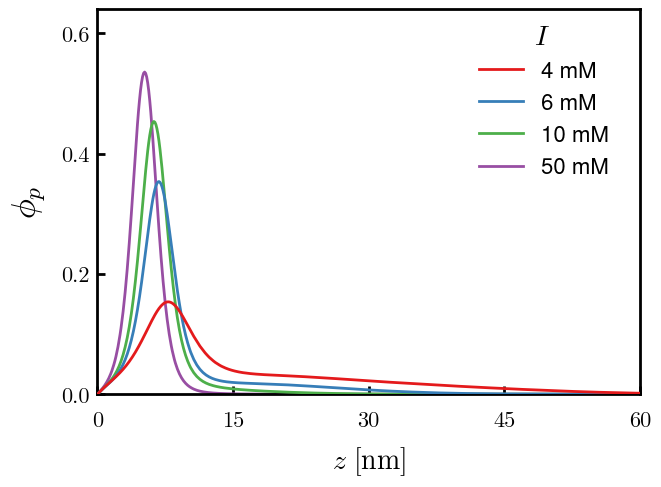

In [55]:
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

block1 = None
labs = ['004', '006', '010', '050']
read_list = [GIT+"pha/phf400_c"+i+".dat" for i in labs]
block_Ni = [[5]]*len(read_list)
zorders = [5,4,3,2]

colors = COLORS
# cividis = mpl.colormaps['magma'].resampled(7)(range(5,0,-1))
# colors=cividis

fig, ax = plt.subplots(1,1, figsize=(7,5)) 

for k in range(len(read_list)):
  block_Nik = block_Ni[k]
  a = 1
  b = 1
  c = 1
  names = ['rx', 'phA']
  for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

  names += ['phB']
  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)

  Nx = len(df.index)
  rows = range(0, Nx)

  rows = range(0, Nx)

  phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phAr = phAr.fillna(0) # with 0s rather than NaNs
  phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
  phAT = phAT.fillna(0) # with 0s rather than NaNs
  ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
  ph1r = ph1r.fillna(0) # with 0s rather than NaNs

  phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phB = phB.fillna(0) # with 0s rather than NaNs

  ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
  ph1r.insert(0, 'rx', df.iloc[:,0])

  phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
  phAT.insert(0, 'rx', df.iloc[:,0])

  for i in range(Nx):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 2 + sum(block_Nik) + len(block_Nik)] 

  lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
  rshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

  # Plot total density (zorder 3)
  lshi[0] = phAr[0] + 0
  rshi[0] = phAr[0] + 0

  ax.plot(lshi[0], phAr.iloc[:,1], color = colors[k], zorder = zorders[k], alpha=1.0, label=labs[k])

  # Plot chain types (zorder 2)
  step = 1
  for j in range(len(block_Nik)):

    #Plot block densities (zorder 3)
    for i in range(block_Nik[j]):
      if (i == block1): ax.plot(lshi[0], ph1r.iloc[:,i+step], ':',  zorder=2, color=tjy.lighten_color(colors[k], 0.60),label='_Block')

    step += block_Nik[j]

conf = [Patch(facecolor=i, edgecolor='k', lw=1.5) for i in colors]
conf += [
          Line2D([0], [0], color='k', ls='-'),
          Line2D([0], [0], color='k', ls='--'),
        ]
plt.ylabel(r'$\phi_p$', fontsize=24)
plt.xlabel(r'$z\ [\mathrm{nm}]$')
plt.ylim(0, 0.64)
plt.yticks(np.arange(0, 0.61, 0.2))
plt.xlim(0, 60)
plt.xticks(np.arange(0, 61, 15))
handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles, ['50 mM', '10 mM', '6 mM', '4 mM'][::-1], bbox_to_anchor=(1.00,  0.48), loc='lower right', fontsize=16)
plt.text(0.82, 0.91, r'$I$', fontsize=20, transform=ax.transAxes, ha='center')
# leg = plt.legend(handles, ['50 mM', '10 mM', '6 mM', '4 mM'][::-1], bbox_to_anchor=(0.55,  0.28), loc='lower right', fontsize=16)
# plt.text(0.37, 0.71, r'$I$', fontsize=20, transform=ax.transAxes, ha='center')

tjy.ticks()
# plt.savefig('./imgs/dens.pdf')
plt.show()

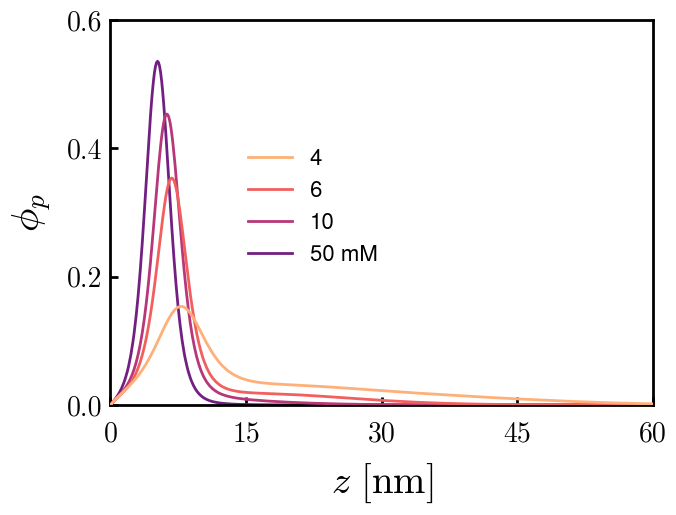

In [57]:
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

block1 = None
labs = ['004', '006', '010', '050']
read_list = [GIT+"pha/phf400_c"+i+".dat" for i in labs]
block_Ni = [[5]]*len(read_list)
zorders = [5,4,3,2]

# colors = COLORS
cividis = mpl.colormaps['magma'].resampled(7)(range(5,0,-1))
colors=cividis

fig, ax = plt.subplots(1,1, figsize=(7,5)) 

for k in range(len(read_list)):
  block_Nik = block_Ni[k]
  a = 1
  b = 1
  c = 1
  names = ['rx', 'phA']
  for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

  names += ['phB']
  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)

  Nx = len(df.index)
  rows = range(0, Nx)

  rows = range(0, Nx)

  phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phAr = phAr.fillna(0) # with 0s rather than NaNs
  phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
  phAT = phAT.fillna(0) # with 0s rather than NaNs
  ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
  ph1r = ph1r.fillna(0) # with 0s rather than NaNs

  phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phB = phB.fillna(0) # with 0s rather than NaNs

  ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
  ph1r.insert(0, 'rx', df.iloc[:,0])

  phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
  phAT.insert(0, 'rx', df.iloc[:,0])

  for i in range(Nx):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 2 + sum(block_Nik) + len(block_Nik)] 

  lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
  rshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

  # Plot total density (zorder 3)
  lshi[0] = phAr[0] + 0
  rshi[0] = phAr[0] + 0

  ax.plot(lshi[0], phAr.iloc[:,1], color = colors[k], zorder = zorders[k], alpha=1.0, label=labs[k])

  # Plot chain types (zorder 2)
  step = 1
  for j in range(len(block_Nik)):

    #Plot block densities (zorder 3)
    for i in range(block_Nik[j]):
      if (i == block1): ax.plot(lshi[0], ph1r.iloc[:,i+step], ':',  zorder=2, color=tjy.lighten_color(colors[k], 0.60),label='_Block')

    step += block_Nik[j]

conf = [Patch(facecolor=i, edgecolor='k', lw=1.5) for i in colors]
conf += [
          Line2D([0], [0], color='k', ls='-'),
          Line2D([0], [0], color='k', ls='--'),
        ]
plt.ylabel(r'$\phi_p$', fontsize=28)
plt.xlabel(r'$z\ [\mathrm{nm}]$',fontsize=28)
plt.ylim(0, 0.60)
plt.yticks(np.arange(0, 0.61, 0.2))
plt.xlim(0, 60)
plt.xticks(np.arange(0, 61, 15))
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
handles, labels = ax.get_legend_handles_labels()
# leg = plt.legend(handles, ['50 mM', '10 mM', '6 mM', '4 mM'][::-1], bbox_to_anchor=(1.00,  0.48), loc='lower right', fontsize=16)
# plt.text(0.82, 0.91, r'$I$', fontsize=20, transform=ax.transAxes, ha='center')
leg = plt.legend(handles, ['50 mM', '10', '6', '4'][::-1], bbox_to_anchor=(0.55,  0.28), loc='lower right', fontsize=16)

tjy.ticks()
plt.savefig('./imgs/dens_aps.pdf')
plt.show()

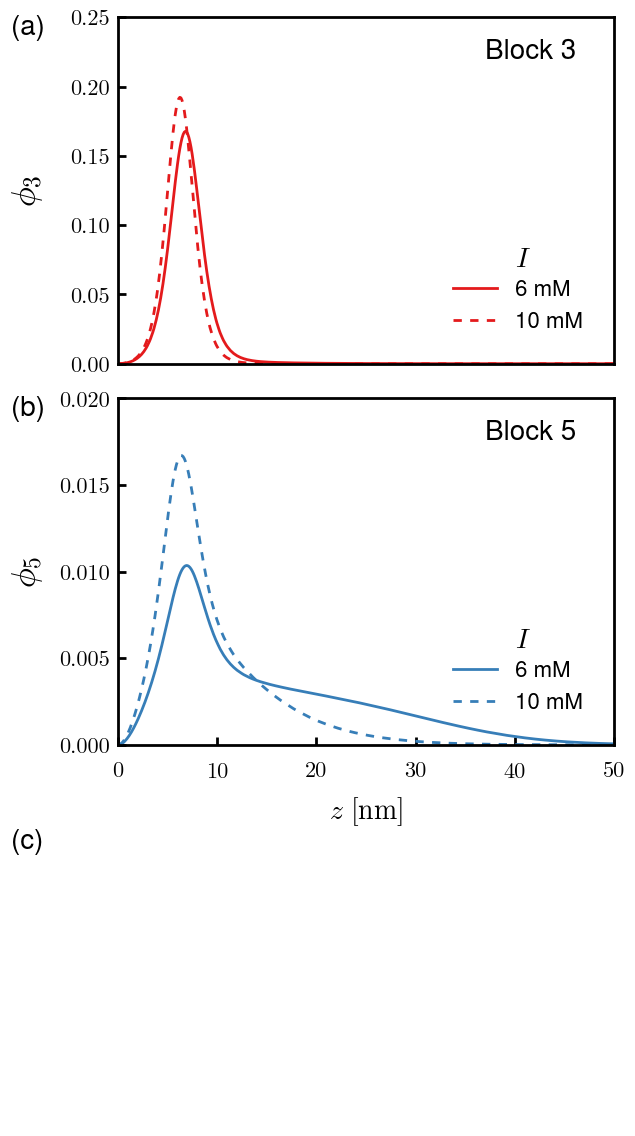

In [7]:
block1 = None
labs = ['010', '006']
lss = [(0, (3,3)), '-']
read_list = [GIT+"pha/phf400_c"+i+".dat" for i in labs]
block_Ni = [[5]]*len(read_list)
             
colors = COLORS

fig, AXS = plt.subplots(3,1, figsize=(plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1]*3))
plt.subplots_adjust(hspace=0.1)
for k in range(len(read_list)):
  block_Nik = block_Ni[k]
  a = 1
  b = 1
  c = 1
  names = ['rx', 'phA']
  for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

  names += ['phB']
  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)

  Nx = len(df.index)
  rows = range(0, Nx)

  rows = range(0, Nx)

  phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phAr = phAr.fillna(0) # with 0s rather than NaNs
  phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
  phAT = phAT.fillna(0) # with 0s rather than NaNs
  ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
  ph1r = ph1r.fillna(0) # with 0s rather than NaNs

  phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  phB = phB.fillna(0) # with 0s rather than NaNs

  ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
  ph1r.insert(0, 'rx', df.iloc[:,0])

  phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
  phAT.insert(0, 'rx', df.iloc[:,0])

  for i in range(Nx):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 2 + sum(block_Nik) + len(block_Nik)] 

  lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
  rshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

  # Plot total density (zorder 3)
  lshi[0] = phAr[0] + 0
  rshi[0] = phAr[0] + 0

  # Plot chain types (zorder 2)
  step = 1
  for j in range(len(block_Nik)):

    #Plot block densities (zorder 3)
    for i in range(block_Nik[j]):
      if (i == 2): 
            AXS[0].plot(lshi[0], ph1r.iloc[:,i+step], c=tjy.lighten_color(colors[0], 1.00), zorder=2, lw=2, ls = lss[k], label='{} mM'.format(int(labs[k])))
      if (i == 4): 
            AXS[1].plot(lshi[0], ph1r.iloc[:,i+step], c=tjy.lighten_color(colors[1], 1.00), zorder=2, lw=2, ls=lss[k], label='{} mM'.format(int(labs[k])))

    step += block_Nik[j]

conf = [Patch(facecolor=i, edgecolor='k', lw=1.5) for i in colors]
conf += [
          Line2D([0], [0], color='k', ls='-'),
          Line2D([0], [0], color='k', ls='--'),
        ]

for block, AX, label in zip([3, 5, None], AXS, ['(a)', '(b)', '(c)']):
    labelx = -0.215
    plt.sca(AX)
    if block: 
        plt.text(labelx, 0.95, label, fontsize=20, transform=AX.transAxes)
        plt.text(0.74, 0.88, 'Block {}'.format(block), fontsize=20, transform=AX.transAxes)
        AX.set_ylabel(r'$\phi_{}$'.format(block), fontsize=24)
        AX.set_xlabel(r"$z\ [\mathrm{nm}]$")
        if block == 3: 
            AX.set_ylim(0, 0.25)
            c = COLORS[0]
        elif block == 5: 
            AX.set_ylim(0, 0.020)
            c = COLORS[1]
        
        AX.set_xlim(0, 50)

        custom_legend = [Line2D([0], [0], color=c, ls = i, lw=2) for i in lss[::-1]]
        handles, labels = AX.get_legend_handles_labels()
        plt.legend(handles=custom_legend, labels=labels[::-1], loc='lower right', fontsize=16)
        plt.text(0.80, 0.28, r'$I$', fontsize=20, transform=AX.transAxes)
        tjy.ticks()
    else:
        plt.text(labelx, 0.8, label, fontsize=20, transform=AX.transAxes)

AXS[0].get_xaxis().set_visible(False)
AXS[2].set_frame_on(False)
AXS[2].set_xticks([])
AXS[2].set_yticks([])
fig.align_ylabels()

# plt.savefig('./imgs/block35.eps')

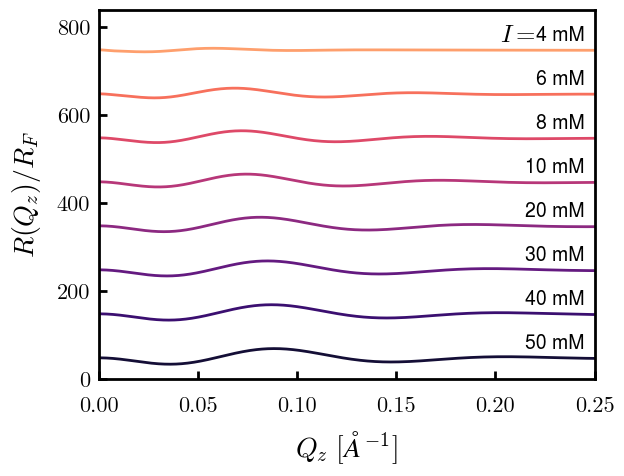

In [8]:
rho_e_w = 3.33e23 # electron density of water, e/cm3 (Source: Braslau, 1985)
rho_e_w *= 1e2**3 / 1e10**3 # e/AA3
r_e = 2.818e-15 # m
r_e *= 1e10 # AA

def RQZ_pha(phname, qz):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    pha = ph[2]
    pha.update(pd.Series([2.32], index=[0])) # electron density of SiO2 substrate, assuming protein electron density 1.0: (CH2)x = 0.95 (Source: Russel, 1990)
    phb = ph[10]
    phe = pha*1.0 + phb*rho_e_w # electron density profile, rho_e_protein = 1.0
    z = ph[0]*10 # nm to AA
    dz = z[1] - z[0]
    dpdz = np.gradient(phe, dz)
    return [RQZ(z, dpdz, i) for i in qz]

def RQZ(z, dpdz, qzi): return np.power(np.absolute(np.trapz(dpdz*np.exp(1j*qzi*z), x=z)/rho_e_w), 2) # j is imaginary

def Z_PHA(phname):
    ph = pd.read_csv(phname, sep="\s+", skiprows=0, header=None)
    ph.iloc[0,1] = 10 # Artificial substrate with 5x electron density as polymer and solvent
    return ph.iloc[:,0:2] 

def RQZ_plot3(shift, qz, filename, color,light_frac):
    plt.plot(qz, shift+np.array(RQZ_pha(filename, qz)), color=color, alpha=1.0)
    return

qz = np.logspace(-3,0,1000) # 0.001 to 1
light_arr = np.linspace(1.0,1.0, 1)
f, ax = plt.subplots(1,1)

labs = (4,6,8,10,20,30,40,50)[::-1]
phs = ['pha/phf400_c{:03d}.dat'.format(i) for i in labs]
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))[::-1]
for row, i in enumerate(cividis): 
    shift = row * 100
    RQZ_plot3(shift, qz, GIT+phs[row], i, light_arr[0])
    plt.annotate('{} mM'.format(labs[row]), (0.245, 70+shift), fontsize=14, ha='right') 
plt.annotate(r'$I =$', (0.220, 68+shift), fontsize=18, ha='right') 

plt.xlim([0.00, 0.25])
plt.ylim([0.00, 840])
plt.ylabel(r'$R(Q_z)/R_F$')
plt.xlabel(r'$Q_z$' ' ' r'$[\AA^{-1}]$')
tjy.ticks()
# plt.savefig('./imgs/refs.eps')
plt.show()

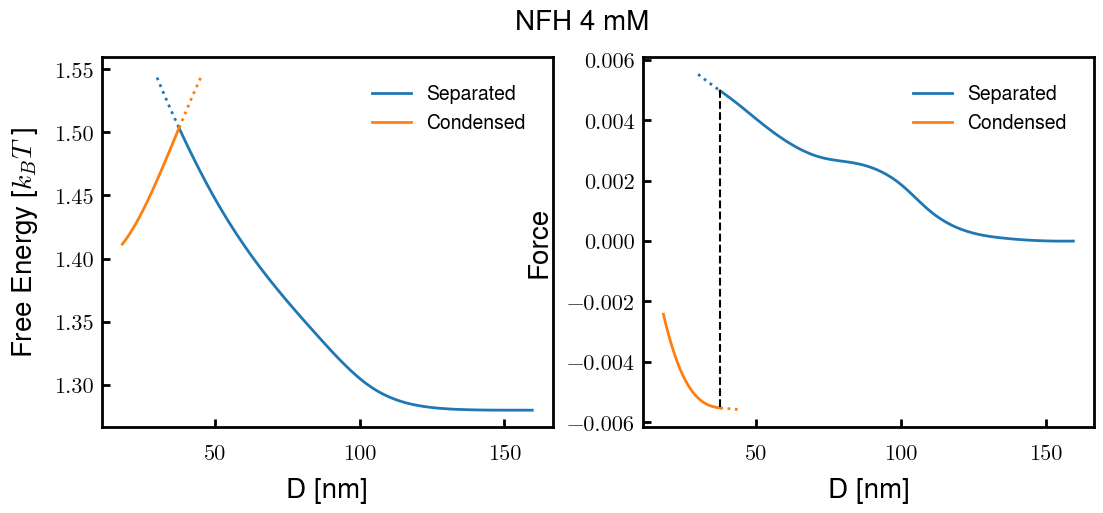

In [9]:
freeE = pd.read_csv(GIT+'int/NFH_04a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04 = freeE.nx, freeE.freeE
d04, x04, f04 = tjy.CalcF(nx, y04)
freeE = pd.read_csv(GIT+'int/NFH_04b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04b = freeE.nx, freeE.freeE
d04b, x04b, f04b = tjy.CalcF(nx, y04b)
freeE = pd.read_csv(GIT+'int/NFH_04c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04c = freeE.nx, freeE.freeE
d04c, x04c, f04c = tjy.CalcF(nx, y04c)
freeE = pd.read_csv(GIT+'int/NFH_04d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04d = freeE.nx, freeE.freeE
d04d, x04d, f04d = tjy.CalcF(nx, y04d)
freeE = pd.read_csv(GIT+'int/NFH_04e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04e = freeE.nx, freeE.freeE
d04e, x04e, f04e = tjy.CalcF(nx, y04e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d04, y04,   **kw, label='_H04a')
    axs[0].plot(d04b, y04b, **kw, label='_H04b')
    axs[0].plot(d04c, y04c, **kw, label='_H04c')
    axs[0].plot(d04d[:4], y04d[:4], **kw, label='_H04d')
    axs[0].plot(d04e, y04e, **kw, label='_H04e')
tosortd, tosorty = [*d04, *d04b, *d04c], [*y04, *y04b, *y04c]
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d04d[:6], *d04e], [*y04d[:6], *y04e]
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04c = UnivariateSpline(XX, YY)

if 0: # 1 to plot, 0 to not
    axs[1].plot(x04, f04,   **kw, label='_H04a')
    axs[1].plot(x04b, f04b, **kw, label='_H04b')
    axs[1].plot(x04c, f04c, **kw, label='_H04c')
    axs[1].plot(x04d[:4], f04d[:4], **kw, label='_H04d')
    axs[1].plot(x04e, f04e, **kw, label='_H04e')
tosortx, tosortf = [*x04, *x04b, *x04c], [*f04, *f04b, *f04c]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x04d[:3], *x04e], [*f04d[:3], *f04e]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_04s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_04c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_04c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_04s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_04c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_04c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 4 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

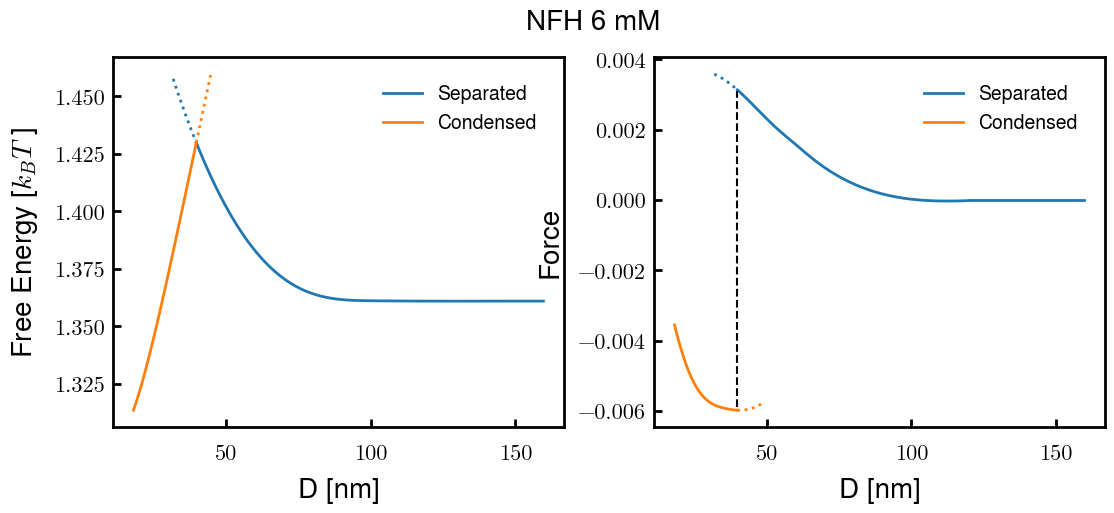

In [10]:
freeE = pd.read_csv(GIT+'int/NFH_06a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06a = freeE.nx, freeE.freeE
d06a, x06a, f06a = tjy.CalcF(nx, y06a)
freeE = pd.read_csv(GIT+'int/NFH_06b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06b = freeE.nx, freeE.freeE
d06b, x06b, f06b = tjy.CalcF(nx, y06b)
freeE = pd.read_csv(GIT+'int/NFH_06c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06c = freeE.nx, freeE.freeE
d06c, x06c, f06c = tjy.CalcF(nx, y06c)
freeE = pd.read_csv(GIT+'int/NFH_06d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06d = freeE.nx, freeE.freeE
d06d, x06d, f06d = tjy.CalcF(nx, y06d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d06a, y06a, **kw, label='_H06a')
    axs[0].plot(d06b, y06b, **kw, label='_H06b')
    axs[0].plot(d06c, y06c, **kw, label='_H06c')
    axs[0].plot(d06d, y06d, **kw, label='_H06d')
tosortx, tosortf = [*d06a, *d06b, *d06c[-16:]], [*y06a, *y06b, *y06c[-16:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d06c[:-16], *d06d], [*y06c[:-16], *y06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06c = UnivariateSpline(XX, YY, s=8e-8)

if 0: 
    axs[1].plot(x06a, f06a, **kw, label='_F06a')
    axs[1].plot(x06b, f06b, **kw, label='_F06b')
    axs[1].plot(x06c, f06c, **kw, label='_F06c')
    axs[1].plot(x06d, f06d, **kw, label='_F06d')
tosortx, tosortf = [*x06a[4:], *x06b], [*f06a[4:], *f06b]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06s = UnivariateSpline(XX, YY, s=2e-08)
tosortx, tosortf = [*x06c[4:-8], *x06d], [*f06c[4:-8], *f06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06c = UnivariateSpline(XX, YY, s=1e-08)

xx = 39.735
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_06s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_06c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 120), F_06s(np.arange(xx, 120)), c='C0', label='Separated') 
axs[1].plot(np.arange(120, 161, 20), [0]*3, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_06c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0031],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 6 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

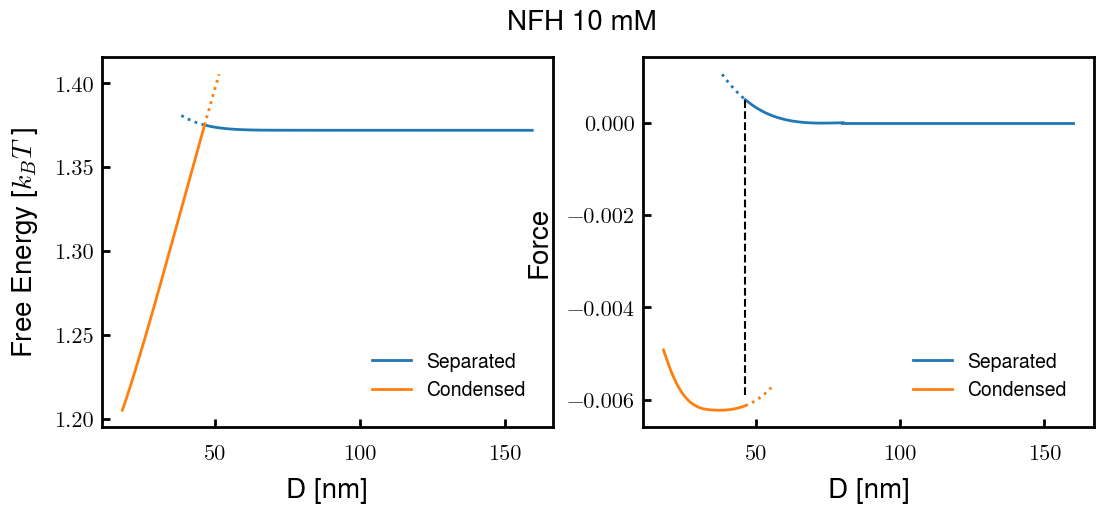

In [11]:
freeE = pd.read_csv(GIT+'int/NFH_10a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10a = freeE.nx, freeE.freeE
d10a, x10a, f10a = tjy.CalcF(nx, y10a)
freeE = pd.read_csv(GIT+'int/NFH_10b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10b = freeE.nx, freeE.freeE
d10b, x10b, f10b = tjy.CalcF(nx, y10b)
freeE = pd.read_csv(GIT+'int/NFH_10c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10c = freeE.nx, freeE.freeE
d10c, x10c, f10c = tjy.CalcF(nx, y10c)
freeE = pd.read_csv(GIT+'int/NFH_10d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10d = freeE.nx, freeE.freeE
d10d, x10d, f10d = tjy.CalcF(nx, y10d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d10a, y10a, **kw, label='_H10a')
    axs[0].plot(d10b, y10b, **kw, label='_H10b')
    axs[0].plot(d10c, y10c, **kw, label='_H10c')
    axs[0].plot(d10d, y10d, **kw, label='_H10d')
tosortx, tosortf = [*d10a, *d10b, *d10c[28:]], [*y10a, *y10b, *y10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d10c[:26], *d10d[:-2]], [*y10c[:26], *y10d[:-2]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10c = UnivariateSpline(XX, YY, s=8e-8)

if 0: 
    axs[1].plot(x10a, f10a, **kw, label='_F10a')
    axs[1].plot(x10b, f10b, **kw, label='_F10b')
    axs[1].plot(x10c[:13], f10c[:13], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10c[15:], f10c[15:], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10d, f10d, **kw, label='_F10d')
tosortx, tosortf = [*x10a, *x10b, *x10c[28:]], [*f10a, *f10b, *f10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x10c[:13], *x10d], [*f10c[:13], *f10d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10c = UnivariateSpline(XX, YY, s=8e-08)

xx = 46.35
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_10s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_10c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()
# axs[0].set_xlim(46, 47)
# axs[0].set_ylim(1.36, 1.38)

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 81), F_10s(np.arange(xx, 81)), c='C0', label='Separated') 
axs[1].plot(np.arange(80, 161, 20), [0]*5, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_10c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0005],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 10 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

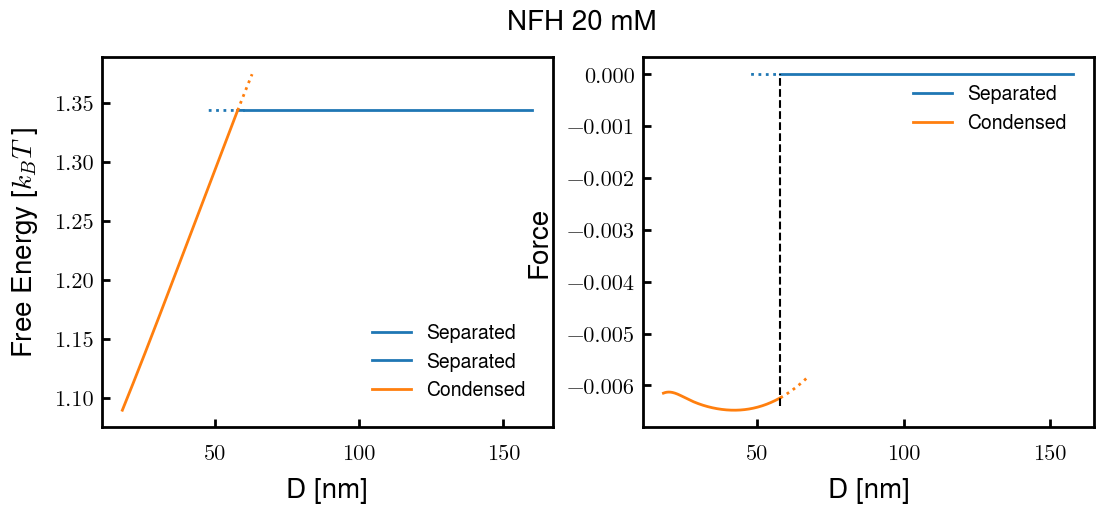

In [12]:
freeE = pd.read_csv(GIT+'int/NFH_20s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x20s, y20s = tjy.CalcF(nx, ys)
freeE = pd.read_csv(GIT+'int/NFH_20c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x20c, y20c = tjy.CalcF(nx, yc)
freeE = pd.read_csv(GIT+'int/NFH_20c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x20c2, y20c2 = tjy.CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20c = UnivariateSpline(XX, YY, s=8e-08)

if 0: 
    axs[1].plot(x20s, y20s, **kw, label='_NFHs')
    axs[1].plot(x20c[5:], y20c[5:], **kw, label='_NFHc')
    axs[1].plot(x20c2, y20c2, **kw, label='_NFHc')
tosortx, tosortf = x20s, y20s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x20c[5:], *x20c2], [*y20c[5:], *y20c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20c = UnivariateSpline(XX, YY, s=8e-08)

xx = 57.94
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 60), H_20s(np.arange(xx, 60)), c='C0', label='Separated') 
axs[0].plot(np.arange(60, 161, 20), H_20s([60]).tolist()*6, c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_20c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_20s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_20c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0064, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 20 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

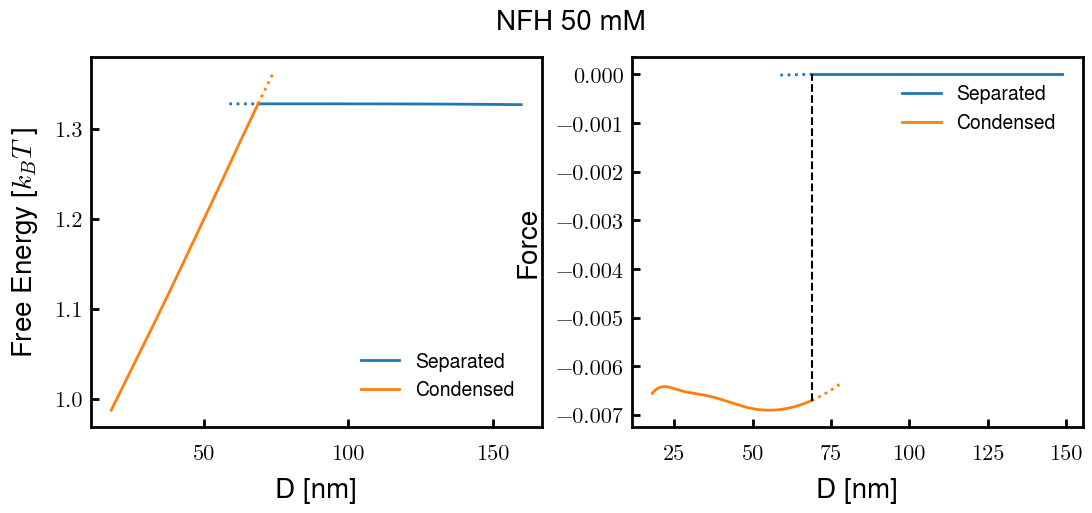

In [13]:
freeE = pd.read_csv(GIT+'int/NFH_50s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x50s, y50s = tjy.CalcF(nx, ys)
freeE = pd.read_csv(GIT+'int/NFH_50c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x50c, y50c = tjy.CalcF(nx, yc)
freeE = pd.read_csv(GIT+'int/NFH_50c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x50c2, y50c2 = tjy.CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50c = UnivariateSpline(XX, YY, s=1e-08)

if 0: 
    axs[1].plot(x50s, y50s, **kw, label='_NFHs')
    axs[1].plot(x50c[5:], y50c[5:], **kw, label='_NFHc')
    axs[1].plot(x50c2, y50c2, **kw, label='_NFHc')
tosortx, tosortf = x50s, y50s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x50c[5:], *x50c2], [*y50c[5:], *y50c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50c = UnivariateSpline(XX, YY, s=6e-08)

xx = 68.85
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_50s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_50c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_50c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0067, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 50 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

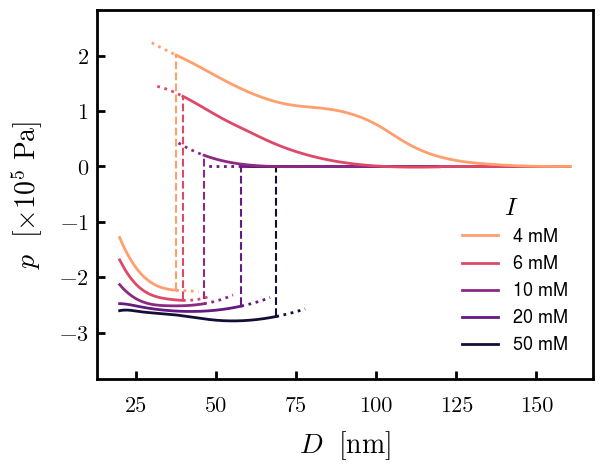

In [14]:
## Plotting
f, ax = plt.subplots(1,1)
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
scaling = 5 # For order unity y-axis
pas *= 10**scaling

# NFH 50
xx = 68.85
c = cividis[7]
plt.plot(np.arange(60, 161, 20),      len(np.arange(60,161,20))*[0], c=c, label='50 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_50c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),        pas*F_50c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0067, 0.00], '--', c=c, lw=1.5)

# NFH 20
xx = 57.94
c = cividis[5]
plt.plot(np.arange(xx-10, xx+0.01, 0.1), pas*F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 161, 20),         len(np.arange(xx,161,20))*[0], c=c, label='20 mM')
plt.plot(np.arange(20, xx+0.01, 0.1),    pas*F_20c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),           pas*F_20c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0062, 0.00],'--', c=c, lw=1.5)

# NFH 10
xx = 46.35
c = cividis[4]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 81),             pas*F_10s(np.arange(xx, 81)), c=c, label='10 mM') 
plt.plot(np.arange(80, 161, 20), [0]*5, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_10c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_10c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0005], '--',c=c,lw=1.5)

# NFH 06
xx = 39.735
c = cividis[2]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 120),            pas*F_06s(np.arange(xx, 120)), c=c, label='6 mM') 
plt.plot(np.arange(120, 161, 20), [0]*3, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_06c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_06c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0031],'--', c=c, lw=1.5)

# NFH 04
xx = 37.62
c = cividis[0]
plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_04s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
plt.plot(np.arange(xx, 161),          pas*F_04s(np.arange(xx,161)), c=c, label='4 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_04c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
plt.plot(np.arange(xx, xx+8),         pas*F_04c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
plt.plot([xx,xx], [pas*-0.0055, pas*0.005], '--', c=c, lw=1.5)

plt.ylim(pas*-0.0095, pas*0.007)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,1), useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(16)
plt.gca().yaxis.offsetText.set_fontfamily('Serif')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='lower right', fontsize=13)
plt.xlabel(r'$D\ \ [\mathrm{nm}]$')
plt.ylabel(r'$p\ \ [\times 10^{:d}$'.format(scaling) + r'$\ \mathrm{Pa}]$')
plt.text(140, -0.87, r'$I$', fontsize=18)
tjy.ticks()
# if True: plt.savefig('./imgs/fprof.eps')
plt.show()

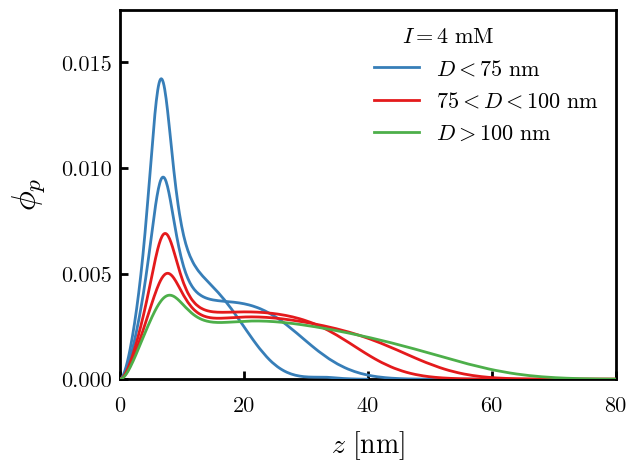

In [15]:
def int_04(ax):
    max_d = 80
    stepL = 0
    step  = 15 
    c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
    colors = (COLORS[1], COLORS[0], COLORS[2])

    f_04 = [70]
    read_04 = [GIT+'int_pha/ph_H04cd{:05d}.dat'.format(int(i*1000)) for i in f_04]
    lshi_04 = [0]*5
    f_06 = (40, 50)
    read_06 = [GIT+'int_pha/ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in f_06]
    lshi_06 = [0]*5
    f_10 = [20, 30]
    read_10 = [GIT+'int_pha/ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in f_10] #+ [GIT+'ph_H10dd12500.dat'] 
    lshi_10 = [0]*5
    
    cs_read = (read_10, read_06, read_04)
    cs_lshi = (lshi_10, lshi_06, lshi_04)
    j_shift = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
    lss = ('-', '-')
    fs = (f_10, f_06, f_04)
    
    for ind in [0, 1, 2]:
        for indj, j in enumerate(range(len(cs_read[ind]))):
            plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], 
                                x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], block1=4, block1_scale = 1, 
                                x1_start = -stepL, x1_end=max_d, ls=lss[indj],
                                y1_start=0, y1_end=0.0175, show=False)

    return [f_04, f_06, f_10], np.array(colors[:3])

def plot_pha_feed(read_file, ax, labs=[], b0=1.0, show=True,
             block_Ni = None, block1 = None, block1_scale = None,
             x1_shift = None, y1_shift = None, ls = None,
             y1_start=0, y1_end=1.00, x1_start=0, x1_end=None, xi_end=None, 
             color='C0', lightf=1.00):
    ## VERSION for single file onto input ax
    
    from matplotlib import animation, rc
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    from matplotlib import ticker
    from urllib.error import HTTPError

    # Defaults
    if not labs:     labs     = read_file
    if not x1_shift: x1_shift = 0
    if not y1_shift: y1_shift = 0
    if not block_Ni: block_Ni = [5]
    if not ls: ls = '-'

    block_Nik = block_Ni
    a = 1
    b = 1
    c = 1
    names = ['rx', 'phA']
    for j in range(len(block_Nik)):
        names += ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
        a += 1
        b += 2
        c += block_Nik[j]

    names += ['phB']
    try: df = pd.read_csv(read_file, sep="\s+", skiprows=0, names=names)

    except HTTPError: 
        print('{} not found'.format(read_file))
    Nx = len(df.index)

    for i in range(len(block_Nik)*2):
        names.remove('*'*(i+1))
        df = df.drop('*'*(i+1),axis=1)

    Nx = len(df.index)
    rows = range(0, Nx)

    phAr = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
    phAr = phAr.fillna(0) # with 0s rather than NaNs
    phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False)
    phAT = phAT.fillna(0) # with 0s rather than NaNs
    ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False)
    ph1r = ph1r.fillna(0) # with 0s rather than NaNs

    phB = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
    phB = phB.fillna(0) # with 0s rather than NaNs

    ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
    ph1r.insert(0, 'rx', df.iloc[:,0])

    # phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
    # phAT.insert(0, 'rx', df.iloc[:,0])

    for i in range(Nx):
        phAr.iloc[i, 0] = df.iloc[i,0]
        phAr.iloc[i, 1] = df.iloc[i,1] 
        phB.iloc[i, 0] = df.iloc[i, 0]
        phB.iloc[i, 1] = df.iloc[i, 1 + sum(block_Nik) + len(block_Nik)] 
        
    lshi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)
    ushi = pd.DataFrame(data=None,  index=rows, columns=range(1), dtype=None, copy=False)

    # Plot total density (zorder 3)
    lshi[0] = phAr.iloc[:xi_end,0] + x1_shift 
    ushi[0] = phAr.iloc[:xi_end,1] + y1_shift

    # Plot chain types (zorder 2)
    step = 1
    for j in range(len(block_Nik)):
    #Plot block densities (zorder 3)
        for i in range(block_Nik[j]):
            if not y1_shift: 
                if (i == block1): 
                    if not block1_scale: ax.plot(lshi[0], ph1r.iloc[:,i+step], ls=ls,  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
                    else: ax.plot(lshi[0], block1_scale*ph1r.iloc[:,i+step], ls=ls,  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
            else: 
                if (i == block1): 
                    if not block1_scale: ax.plot(lshi[0], ph1r.iloc[:,i+step]+y1_shift, '-',  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')
                    else: ax.plot(lshi[0], block1_scale*ph1r.iloc[:,i+step]+y1_shift, '-',  zorder=3, color=tjy.lighten_color(color, amount=lightf),label='_Block')

        step += block_Nik[j]

    conf = [Patch(facecolor=color, edgecolor='k', lw=1.5)]
    conf += [
              Line2D([0], [0], color='k', ls='-'),
              Line2D([0], [0], color='k', ls='--'),
            ]
    tjy.ticks()        
    plt.ylabel(r'$\phi_p$', fontsize=24)
    ax.set_xlabel(r'$z\ [\mathrm{nm}]$')
    ax.set_yscale('linear')
    ax.set_ylim(y1_start, y1_end)
    ax.set_xlim(x1_start, x1_end)
    if show: plt.show()
    
    return ax

nf, naxs = plt.subplots(1,1)
int_04p, int_04c = int_04(naxs)
naxs.set_yticks([0, 0.005, 0.01, 0.015])
naxs.set_ylabel(r'$\phi_p$')

## LEGENDS ## 
custom_legend = [Line2D([0], [0], color=int_04c[i], lw=2) for i in range(3)]
plt.text(0.57, 0.91, r'$I = 4\ \mathrm{mM}$', transform=naxs.transAxes, fontsize=16)
labs = [r'$D < 75\ \mathrm{nm}$', r'$75 < D <  100\ \mathrm{nm}$', r'$D > 100\ \mathrm{nm}$'] 
naxs.legend(handles=custom_legend, labels=labs, bbox_to_anchor=(1.03, 0.95), loc='upper right', fontsize=16)

## TEXTS ## 
cd_factor = 0.7 # Text color darkening factor
bbox=dict(boxstyle='square,pad=0.1', facecolor='white', edgecolor='none')
props = lambda c: dict(xycoords='data', textcoords='data', c=c, fontsize=18, va='center', ha='left', bbox=bbox)
plt.annotate(r'', xy=(12, 0.0120), **props(int_04c[0]*cd_factor))
plt.annotate(r'', xy=(14, 0.0090), **props(int_04c[0]*cd_factor))
plt.annotate(r'', xy=(17, 0.0060), **props(int_04c[1]))
plt.annotate(r'',xy=(30, 0.0040), **props(int_04c[1]))
plt.annotate(r'',xy=(48, 0.0025), **props(int_04c[2]*cd_factor))
tjy.ticks()
# plt.savefig('./imgs/fdens2.eps')

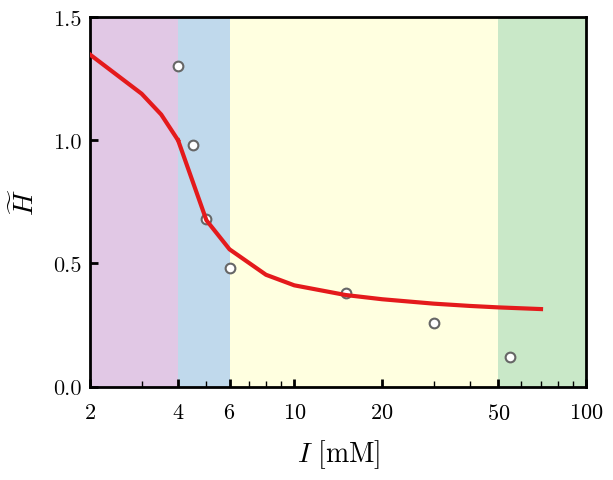

In [16]:
f, ax = plt.subplots(1,1)

# Main
ax.plot(SrCs[3:], Sr_equil[3:], '-', c=COLORS[0], lw=3, markerfacecolor='w', zorder=3, label="")
ax.plot(SrCs[:4], Sr_equil[:4], '-', c=COLORS[0], lw=3, markerfacecolor='w', zorder=3, label=" ")
ax.plot(x, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label=" ")

x0, xf = 2.0, 100
y0, yf = 0., 1.5
xys  = ((2, y0), (4, y0), (6, y0), (50, y0)) # Lower right vertex of rect
ws = [ xys[i+1][0] - xys[i][0] for i in range(3)] + [xf - xys[-1][0]]
for ind, i in enumerate(xys):
    r = mpl.patches.Rectangle(i, ws[ind], yf-y0, ec="none", color=tjy.lighten_color(COLORS2[1::][ind], 0.30))
    ax.add_artist(r)

# ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
ax.set_xscale('log')
ax.set_xlim(x0, xf)
ax.set_xticks([2, 4, 6, 10, 20, 50, 100])
ax.set_ylim(y0, yf)
ax.set_yticks([0.0, 0.5, 1.0, 1.5] )
ax.set_ylabel(r'$\widetilde{H}$')
ax.set_xlabel(r'$I\ [\mathrm{mM}]$')

class xScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%d$" # New precision
class yScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%.1f$" # New precision
ax.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
axins.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))
axins.yaxis.set_major_formatter(yScalarFormatterClass(useMathText=True))
axins.xaxis.set_tick_params(labelsize=14)
axins.yaxis.set_tick_params(labelsize=14)

# plt.gcf().text(0.000, 0.82, '(a)', fontsize=24)
tjy.ticks()
# 
# plt.savefig('./imgs/hprof_TOC.eps')
plt.show()

norm
salt-free LH1:  32.88634733284891
salt-free LH3:  35.17106099352394
salt-free LH4:  31.20298883845959
salt-free LH5:  40.21533381829786
[6.816703127353185, 5.565814796683214, 5.152943210380796, 4.820137006686982, 4.311261603125781, 3.935625385563126, 3.4083515636765926, 3.048522315039426, 2.489108047111568, 2.1556308015628907, 1.7600651792185937, 1.524261157519713, 1.363340625470637, 1.1522331302607458]
[4.820137006686982, 4.54446875156879, 4.311261603125781, 3.935625385563126, 2.489108047111568, 1.7600651792185937, 1.2998942827849391]


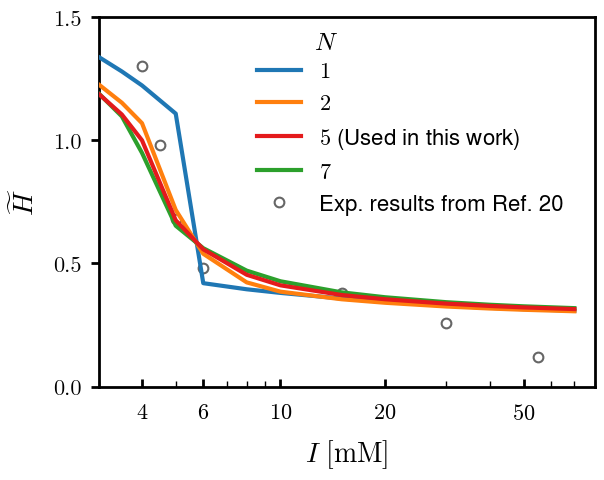

In [2]:
## NFH
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

from datetime import datetime
labs  =  ['002', '003', '0035', '004', '005', '006', '008', '010', '015', '020', '030', '040', '050', '070']
labs2 =  ['002', '003', '0035', '004', '0045', '005', '006', '008', '010', '015', '020', '030', '040', '050', '070']
tack = [0]*len(labs) #see add for options
tack2 = [0]*len(labs2) #see add for options
add = ['', '_1C', '_']
read1 = ['phf400_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
# read2= ['phf4008_c'+add[tack2[ind]]+i+'.dat' for ind, i in enumerate(labs2)]
read3= ['phf4002_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
read4= ['phf4007_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]
read5= ['phf4001_c'+add[tack[ind]]+i+'.dat' for ind, i in enumerate(labs)]

read1 = [GIT+'rev_pha/'+i for i in read1]
# read2 = [GIT+'rev_pha/'+i for i in read2]
read3 = [GIT+'rev_pha/'+i for i in read3]
read4 = [GIT+'rev_pha/'+i for i in read4]
read5 = [GIT+'rev_pha/'+i for i in read5]
algs = ['thresh', 'maxpt', 'norm']

##########################################
##########################################
norms = [250, 55, 32.9] # 31.5
thresh = 1e-04
##########################################
##########################################

algind = 2
print(algs[algind])
LH1 = np.zeros(len(read1))
# LH2 = np.zeros(len(read2))
LH3 = np.zeros(len(read3))
LH4 = np.zeros(len(read4))
LH5 = np.zeros(len(read5))
for i in range(len(read1)):
    LH1[i] = tjy.H_find(read1[i], alg=algs[algind], thresh=thresh)
    if labs[i] == '004': print("salt-free LH1: ", LH1[i])
    LH3[i] = tjy.H_find(read3[i], alg=algs[algind], thresh=thresh)
    if labs[i] == '004': print("salt-free LH3: ", LH3[i])
    LH4[i] = tjy.H_find(read4[i], alg=algs[algind], thresh=thresh)
    if labs[i] == '004': print("salt-free LH4: ", LH4[i])
    LH5[i] = tjy.H_find(read5[i], alg=algs[algind], thresh=thresh)
    if labs[i] == '004': print("salt-free LH5: ", LH5[i])
# for i in range(len(read2)): 
#     LH2[i] = tjy.H_find(read2[i], alg=algs[algind], thresh=thresh)
#     if labs2[i] == '004': print("salt-free LH2: ", LH2[i])

####################

SrCs = [float(i) for i in labs]
SrCs[2] = 3.5
SrCs2 = [float(i) for i in labs2]
SrCs2[2] = 3.5
SrCs2[4] = 4.5
Sr1 = np.divide(LH1,  norms[algind])
Sr3 = np.divide(LH3,  norms[algind])
Sr4 = np.divide(LH4,  norms[algind])
Sr5 = np.divide(LH5,  norms[algind])
CsDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in SrCs]
print(CsDeb)

#Sr2014 pH2.4 fitted in Illustrator
x = [4, 4.5, 5, 6, 15, 30, 55]
y = [1.3, 0.98, 0.68, 0.48, 0.38, 0.26, 0.12]
xDeb = [1/tjy.Kap_D(i*1e-3)*1e9 for i in x]
print(xDeb)

f, ax = plt.subplots(1,1)
# Main
ax.plot(SrCs, Sr5, '-', lw=3,  zorder=3, label=r"$1$")
ax.plot(SrCs, Sr3, '-', lw=3,  zorder=3, label=r"$2$")
ax.plot(SrCs, Sr1, '-', c=COLORS[0], lw=3, zorder=5, label=r"$5$ (Used in this work)")
ax.plot(SrCs, Sr4, '-', lw=3,  zorder=3, label="$7$")
ax.plot(x, y, 'o', c=tjy.lighten_color('k', 0.60), mew=1.5, ms=7, markerfacecolor='w',label="Exp. results from Ref. 20")

## Formatting
ax.legend(bbox_to_anchor=(1.00,  0.38), loc='lower right', fontsize=16)
ax.set_xscale('log')
ax.set_xlim(3.0, 80)
ax.set_xticks([4, 6, 10, 20, 50])
ax.set_ylim(0., 1.5)
ax.set_yticks([0.0, 0.5, 1.0, 1.5] )
ax.set_ylabel(r'$\widetilde{H}$')
ax.set_xlabel(r'$I\ [\mathrm{mM}]$')

class xScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%d$" # New precision
class yScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%.1f$" # New precision
ax.xaxis.set_major_formatter(xScalarFormatterClass(useMathText=True))

tjy.ticks()
plt.text(12.5, 1.37, r'$N$', fontsize=18)
plt.savefig('./imgs/sens.pdf')
plt.show()

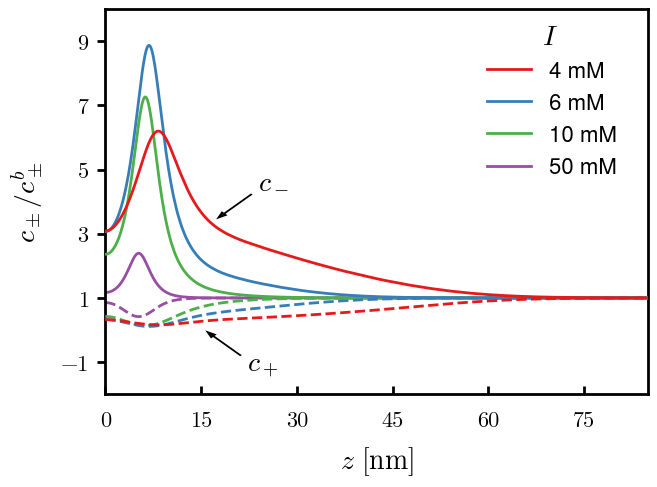

In [3]:
c1 = [122/255, 28/255, 188/255]
c2 = [252/255, 159/255, 128/255]

block1 = None
labs = ['004', '006', '010', '050']
read_list = [GIT+"el/elf400_c"+i+".dat" for i in labs]
zorders = [5,4,3,2]
             
colors = COLORS

fig, ax = plt.subplots(1,1, figsize=(7,5)) 

## PLOT MAIN###########################################
for k in range(len(read_list)):
  names = ['rx', 'psi', 'cp', 'cm', 'elp']
  bulk = float(labs[k])*1e-3 * 6.022e23*1e3*1e-09**3

  try: df = pd.read_csv(read_list[k], sep="\s+", skiprows=0, names=names)
  except HTTPError: 
      print('{} not found'.format(read_list[k]))
  Nx = len(df.index)

  rows = range(0, Nx)

  psi = pd.DataFrame(data=None, index=rows, columns=range(2), dtype=None, copy=False)
  psi = psi.fillna(0) # with 0s rather than NaNs

  cpm = pd.DataFrame(data=None, index=rows, columns=range(3), dtype=None, copy=False)
  cpm = cpm.fillna(0) # with 0s rather than NaNs

  for i in range(Nx):
    psi.iloc[i, 0] = df.iloc[i, 0]
    psi.iloc[i, 1] = df.iloc[i, 1] 
    cpm.iloc[i, 0] = df.iloc[i, 0]
    cpm.iloc[i, 1] = df.iloc[i, 2]
    cpm.iloc[i, 2] = df.iloc[i, 3]

  ax.plot(cpm.iloc[:,0], cpm.iloc[:,1]/bulk, '-',  color = colors[k], zorder = zorders[k], alpha=1.0, label=labs[k])
  ax.plot(cpm.iloc[:,0], cpm.iloc[:,2]/bulk, '--', color = colors[k], zorder = zorders[k], alpha=1.0, label='_none')

plt.ylabel(r'$c_\pm/c_\pm^b$')
plt.ylim(-2, 10)
plt.yticks([-1, 1, 3, 5, 7, 9])
plt.xlabel(r'$z\ [\mathrm{nm}]$')
plt.xlim(0, 85)
plt.xticks(np.arange(0, 81, 15))
handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles, ['50 mM', '10 mM', '6 mM', '4 mM'][::-1], bbox_to_anchor=(1.00,  0.48), loc='lower right', fontsize=16)
plt.text(0.82, 0.91, r'$I$', fontsize=20, transform=ax.transAxes, ha='center')

plt.text(0.31, 0.54, r'$c_-$', fontsize=20, transform=ax.transAxes, ha='center')
plt.arrow(0.27, 0.52, -0.05, -0.05, width=0.004, head_width=0.015, ec='None', fc='k', transform=ax.transAxes, clip_on=False)

plt.text(0.29, 0.06, r'$c_+$', fontsize=20, transform=ax.transAxes, ha='center')
plt.arrow(0.25, 0.10, -0.05,  0.05, width=0.004, head_width=0.015, ec='None', fc='k', transform=ax.transAxes, clip_on=False)

tjy.ticks()
plt.savefig('./imgs/els.pdf')
plt.show()